In [1]:
# load packages
import mne as mne
mne.set_log_level('error')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/Kya_Masoumi/anaconda3/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


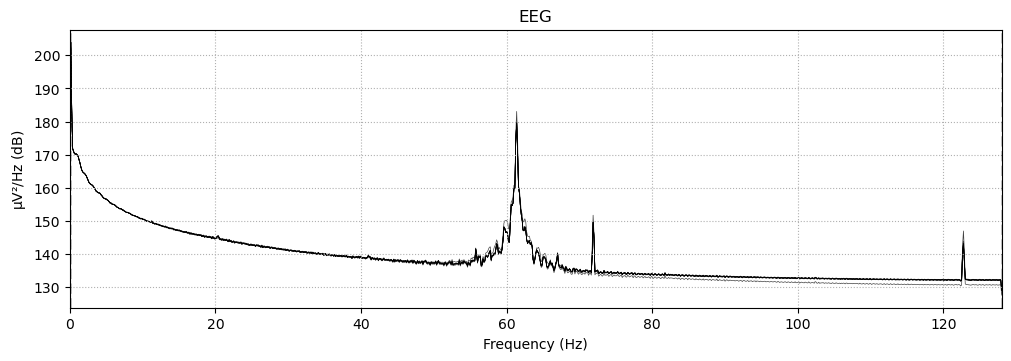

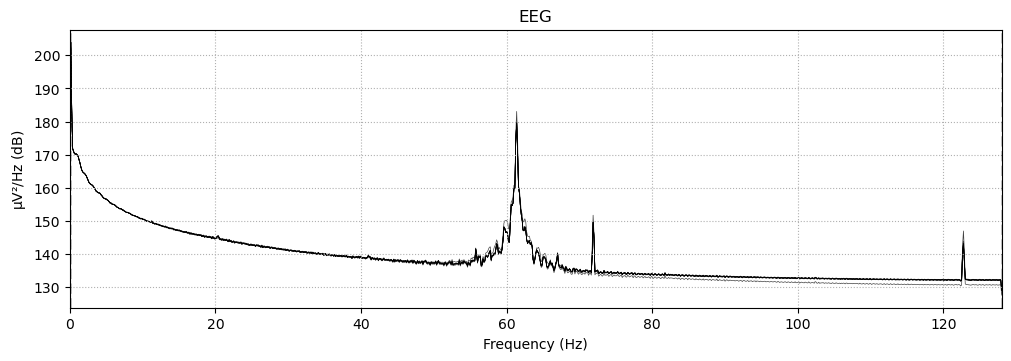

In [2]:
# load data from .csv file name 'combined_recording_##########.csv' from data/recordings folder, use columns 0-7, 17, 19
data = pd.read_csv('data/recordings/combined_recording_1701570005.csv', usecols=[0,1,2,3,4,5,6,7,18,20])

# channel info (check electode placement/name and columsn in data)
ch_names = ['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'Type', 'TimeStamp']
sfreq = 256  # sampling frequency in Hz

# channel types (8 channels of EEG data and 2 for image type and stimulus time)
ch_types = ['eeg'] * 8 + ['misc'] * 2

# create info object and raw data object
info = mne.create_info(ch_names, sfreq, ch_types=ch_types)
raw = mne.io.RawArray(data.T, info)
raw.plot_psd()

In [3]:
# raw.set_montage('standard_1020')

raw.apply_function(lambda x: x * 1e-6)

raw.filter(2,30, method='fft')

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"8 EEG, 2 misc"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,2.00 Hz
Lowpass,30.00 Hz


In [4]:
# isolate the image stimulus
events = mne.find_events(raw, stim_channel='TimeStamp')

# isolate image stimulus events
i = 0
for e in events:
    events = np.insert(events, i, [e[0]-200, 2, 0], axis=0)
    i+=2

for e in events:
    if e[2] == 1:
        e[1] = 1
        e[2] = 0

events = mne.find_events(raw, stim_channel='TimeStamp')

# isolate on task events
i = 0
for e in events:
    events = np.insert(events, i, [e[0]-200, 0, 2], axis=0)
    i+=2

# set event_id equal to channel 9 (Type) value 1 or 2
event_id = {'on_task': 1, 'off_task': 2}


In [5]:
# print unique values in last colum of events and event_id
print("Unique values in events:", np.unique(events[:, -1]))
print("Event ID dictionary:", event_id)

event_values = raw._data[ch_names.index('TimeStamp')]
print("Event values in the raw data:", np.unique(event_values))

Unique values in events: [     2 354724 354725 354726 354727 354728 354729 354730 354731 354732
 354733 354734 354735 354736 354737 354738 354739 354740 354741 354742
 354743 354744 354745 354746 354747 354748 354749 354750 354751 354752
 354753 354754 354755 354756 354757 354758 354759 354760 354761 354762
 354763 354764 354765 354766 354767 354768 354769 354770 354771 354772
 354773 354774 354775 354776 354777 354778 354779 354780 354781 354782
 354783 354784 354785 354786 354787 354788 354789 354790 354791 354792
 354793 354794 354795 354796 354797 354798 354799 354800 354801 354802
 354803 354804 354805 354806 354807 354808 354809 354810 354811 354812
 354813 354814 354815 354816 354817 354818 354819 354820 354821 354822
 354823 354824 354825 354826 354827 354828 354829 354830 354831 354832
 354833 354834 354835 354836 354837 354838 354839 354840 354841 354842
 354843 354844 354845 354846 354847 354848 354849 354850 354851 354852
 354853 354854 354855 354856 354857 354858 354859 35

In [6]:
print(raw._data.shape)
print(raw.info.keys())
raw.info

(10, 35987)
dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"8 EEG, 2 misc"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,2.00 Hz
Lowpass,30.00 Hz


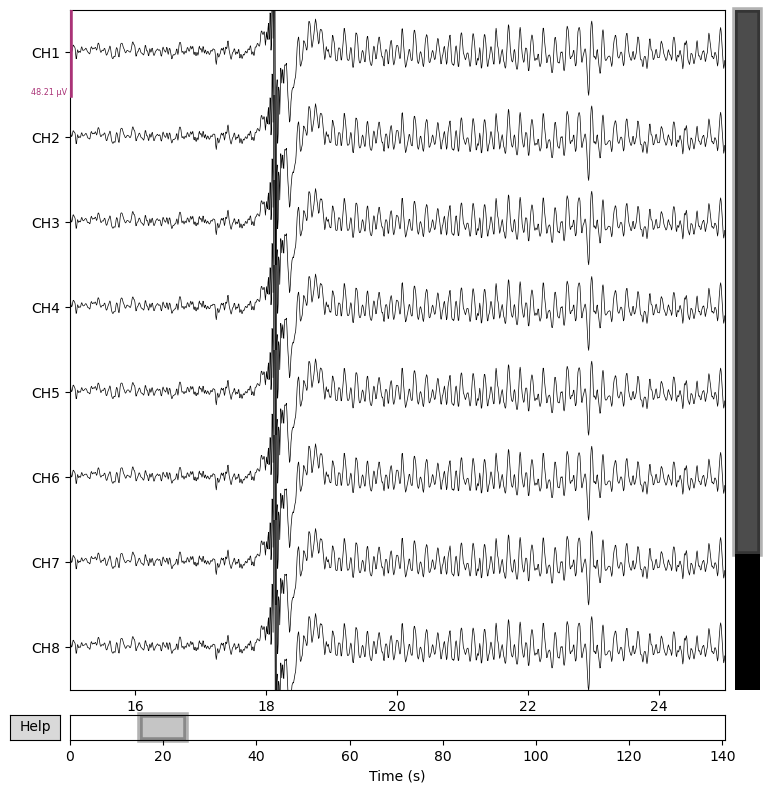

/Users/Kya_Masoumi/anaconda3/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


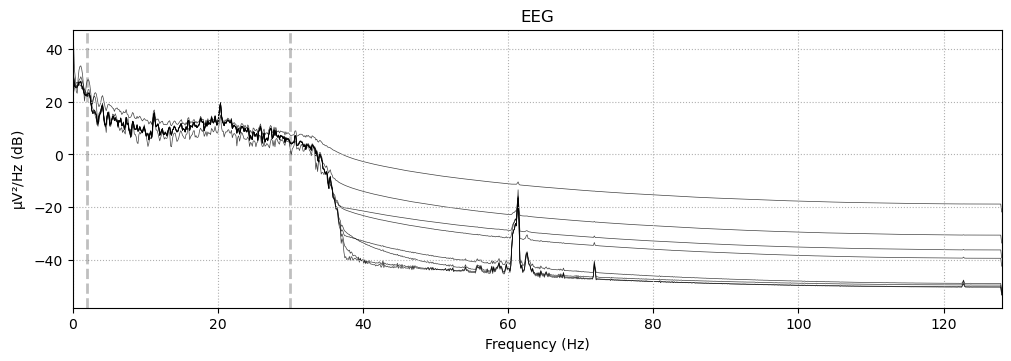

In [7]:
raw.plot(start=15, duration=10, n_channels=8, scalings='auto')
raw.compute_psd().plot()

In [8]:
#calculate scan duration
scan_durn = raw._data.shape[1] / raw.info['sfreq']
scan_durn

140.57421875

In [10]:
# make epochs
epochs = mne.Epochs(raw, events, tmin=0, tmax=scan_durn, baseline=None, proj=False, detrend=1, preload=True, event_repeated='merge',
                    reject = dict(eeg=1e-3))

labels = epochs.events[:, -1]
psd = epochs.compute_psd(method='multitaper', tmin=0, tmax=scan_durn, fmin=2, fmax=30, picks='eeg')


RuntimeError: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.

In [11]:
# convert to db and reshape
psd_db = 10 * np.log10(psd)
psd_db = psd_db.reshape(psd_db.shape[0], psd_db.shape[1], psd_db.shape[2] * psd_db.shape[3])


NameError: name 'psd' is not defined

In [ ]:
# linear discriminant analysis
